In [1]:
import numpy as np
import matplotlib.pyplot as plt


q_learning   e_greedy
← ↓ → → ↑ ↑ → → → ↓ → ↓ 
↓ ↓ → ↓ → ↓ ↓ ↓ ↓ ↓ ↓ ↓ 
→ → → → → → → → → → → ↓ 
↑ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ 

q_learning   softmax
→ → → → → → → → → → → ↓ 
↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ 
→ → → → → → → → → → → ↓ 
↑ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ 

q_learning   greedy
← ↓ → → → ↑ → → → → → ↓ 
← → → ↓ → → ↓ → ↓ → ↓ ↓ 
→ → → → → → → → → → → ↓ 
↑ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ 

sarsa   e_greedy
→ → → → → → → → → → ↓ ↓ 
→ ↑ → ↑ → ↑ → → → ↑ → ↓ 
↑ ↑ ↑ ↑ → ↑ → ↑ ↑ ↑ → ↓ 
↑ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ 

sarsa   softmax
← ↓ → → → → ↓ → ↓ ↓ ↓ ↓ 
↓ → → ↓ ↓ ↓ → ↓ → ↓ ↓ ↓ 
→ → → → → → → → → → → ↓ 
↑ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ 

sarsa   greedy
↑ → → → ↑ ← ↓ → → → ↓ ↓ 
→ ↓ → → → ↓ → → → ↓ ↓ ↓ 
→ → → → → → → → → → → ↓ 
↑ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ 


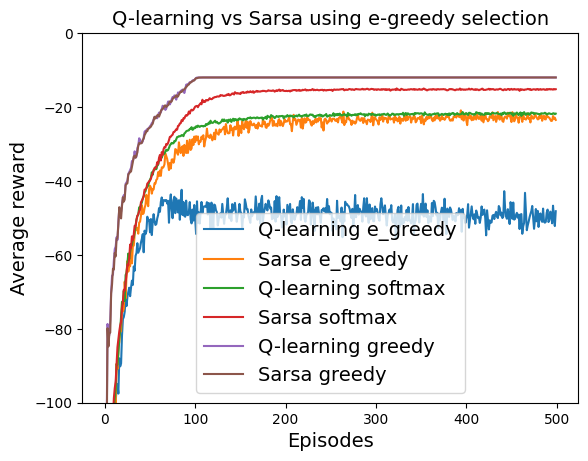

In [3]:
PLAYER = 'P'
SPACE  = '.'
WALL = '#'
TRAP = "X"
GOAL = "G"

DOWN = "down"
LEFT = "left"
RIGHT = "right"
UP = "up"

ACTIONS = [DOWN,LEFT,RIGHT,UP]

class Game:
    def __init__(self,filePath):
        """
        Assumes a txt file at `filePath` that is structured like this:\n
        5 6 \n
        ##### \n
        #...# \n
        #.XG# \n
        P..C# \n
        #...# \n
        ##### \n

        Where the first line contains 2 numbers that represent the width and height of the grid.

        \# = Wall \n
        . = Open Space \n
        P = Player \n
        F = GOAL position \n
        X = Trap \n


        """
        self.map = []
        f = open(filePath, "r")
        self.score = 0
        self.finished = False
        for index,line in enumerate(f.readlines()):
            if(index == 0):
                sizes = line.split(" ")
                self.width = int(sizes[0])
                self.height = int(sizes[1])
            else:
                row = []
                for i in range(self.width):
                    character = line[i]

                    if character == PLAYER:
                        row.append(SPACE)
                        self.start_position = {
                            "x": i,
                            "y": index - 1
                        }
                        self.player = {
                            "x": i,
                            "y": index - 1
                        }
                    else:
                        row.append(character)
                self.map.append(row)

    def execute(self,action):
        """Executes the `action` provided. Every action that gets taken `self.score` gets subtracted by 1"""
        px = self.player["x"]
        py = self.player["y"]

        if(action == "up"):
            if(py != 0 and self.map[py - 1][px] != WALL):
                self.player["y"] -= 1
        elif(action == "down"):
            if(py != self.height - 1 and self.map[py + 1][px] != WALL):
                self.player["y"] += 1
        elif(action == "left"):
            if(px != 0 and self.map[py][px - 1] != WALL):
                self.player["x"] -= 1
        elif(action == "right"):
            if(px != self.width - 1 and self.map[py][px + 1] != WALL):
                self.player["x"] += 1
        
        if self.isPlayerOnTrap():

            self.score += -100
            self.player["y"] = self.start_position["y"]
            self.player["x"] = self.start_position["x"]
            return -100

        if self.isPlayerOnGOAL():
            self.finished = True
            return 0

        self.score += -1
        return -1
     
    def isPlayerOnTrap(self):
        """Returns `True` if the player is currently on a trap"""
        if self.map[self.player["y"]][self.player["x"]] == TRAP:
            return True

    def isPlayerOnGOAL(self):
        """Returns `True` if the player is currently on a GOAL"""
        if self.map[self.player["y"]][self.player["x"]] == GOAL:
            return True


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


class Algorithm:
    def __init__(self, map_name, discount_factor=1, learning_rate=0.3, explore_rate=0.1):

        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.explore_rate = explore_rate

        self.map_name = map_name
        self.game = Game(map_name)
        
        with open(map_name, "r") as f:
            sizes = f.readline().split(" ")
            self.width = int(sizes[0])
            self.height = int(sizes[1])
        
        self.state = self.game.player["x"]+self.game.player["y"]*self.width

        self.q = np.zeros((self.width*self.height, len(ACTIONS)), dtype=np.float16)

    def __call__(self, algorithm, selection_method="e_greedy", episodes=20):
        """
        Play the game 'episodes' times and update the q values using the algorithm 'algorithm'.
        """
        scores = []
        if algorithm == "sarsa":
            for _ in range(episodes):
                # Choose action
                action_index = self.action_selection(self.state, selection_method)
                action = ACTIONS[action_index]

                while not self.game.finished:
                    # Execute action and get reward and new state
                    reward = self.game.execute(action)
                    new_state = self.game.player["x"]+self.game.player["y"]*self.width

                    # Choose new action index
                    new_action_index = self.action_selection(new_state, selection_method)

                    # Calculate variables needed for updating the q value
                    dmefr = self.discount_factor*self.q[new_state][new_action_index]
                    current_q = self.q[self.state][action_index]

                    # Update q value
                    self.q[self.state][action_index] += self.learning_rate*(reward+dmefr-current_q)

                    # Update state and action
                    self.state = new_state
                    action_index = new_action_index
                    action = ACTIONS[action_index]


                scores.append(self.game.score)

                # Reset game
                self.reset()

            # Return the q matrix
            return self.q, scores

        elif algorithm == "q_learning":
            for _ in range(episodes):
                while not self.game.finished:

                    # Choose action
                    action_index = self.action_selection(self.state, selection_method)
                    action = ACTIONS[action_index]

                    # Execute action and get reward and new state
                    reward = self.game.execute(action)
                    new_state = self.game.player["x"]+self.game.player["y"]*self.width

                    # Calculate variables needed for updating the q value
                    dmefr = self.discount_factor*max(self.q[new_state])
                    current_q = self.q[self.state][action_index]

                    # Update q value
                    self.q[self.state][action_index] += self.learning_rate*(reward+dmefr-current_q)

                    # Update state
                    self.state = new_state

                scores.append(self.game.score)

                # Reset game
                self.reset()

            # Return the q matrix
            return self.q, scores
        raise ValueError("Algorithm not found")


    def reset(self):
        """Reset the game"""
        self.game = Game(self.map_name)
        self.state = self.game.player["x"]+self.game.player["y"]*self.width

    def action_selection(self, state, selection_method):
        """
        Returns the index of a action.
        This is a random action if a random integer between 0 and 1 is smaller then the explore rate.
        If this is not the case return the action with the highest q value.
        """
        if selection_method == "e_greedy":
            # If a random number is within the explore rate we explore by choosing a random action
            if np.random.uniform(0,1) <= self.explore_rate:
                return np.random.choice(range(len(ACTIONS)))
            
            # If we don't explore we choose the action with the highest reward 
            # If there are multiple actions with the same reward we choose one of them randomly
            max = np.max(self.q[state])
            indexes = [i for i, x in enumerate(self.q[state]) if x == max]
            return np.random.choice(indexes)

        elif selection_method == "softmax":
            # Choose an action based on the softmax function
            return np.random.choice(range(len(ACTIONS)), p=softmax(self.q[state]))

        elif selection_method == "greedy":
            # Choose the action with the highest reward if there are multiple actions 
            # with the same reward we choose one of them randomly
            max = np.max(self.q[state])
            indexes = [i for i, x in enumerate(self.q[state]) if x == max]
            return np.random.choice(indexes)
        
        raise ValueError("Selection method not found")


def compare_performance():
    map = "./map.txt"

    # Running this function with 1000 and episodes to 500 can take a while
    runs = 1000
    episodes = 500
    selection_methods = ["e_greedy", "softmax", "greedy"]

    for selection_method in selection_methods:

        # Initialize the running averages for the rewards at 0
        avr_reward_q_learning = [0 for _ in range(episodes)]
        avr_reward_sarsa = [0 for _ in range(episodes)]

        # Run the algorithms 'runs' times to even out the randomness
        for _ in range(runs):
            # Initialize the algorithms
            q_learning_algo = Algorithm(map)
            sarsa_algo = Algorithm(map)
            
            # Run the algorithms
            q, scores_q_learning = q_learning_algo("q_learning", selection_method=selection_method, episodes=episodes)
            q, scores_sarsa = sarsa_algo("sarsa", selection_method=selection_method, episodes=episodes)
            
            # Add the rewards to the running averages
            avr_reward_q_learning = [x+(y/runs) for x,y in zip(avr_reward_q_learning, scores_q_learning)]
            avr_reward_sarsa = [x+(y/runs) for x,y in zip(avr_reward_sarsa, scores_sarsa)]

        # Add the results of the algorithms for the current selection method to the plot
        plt.plot(avr_reward_q_learning, label="Q-learning "+selection_method)
        plt.plot(avr_reward_sarsa, label="Sarsa "+selection_method)

    # Plot the results of the algorithms
    plt.ylim([-100, 0])
    plt.legend(fontsize=14)
    # plt.title("Comparison of Q-learning and Sarsa with different selection methods")
    plt.title("Q-learning vs Sarsa using e-greedy selection", fontsize=14)
    plt.xlabel("Episodes", fontsize=14)
    plt.ylabel("Average reward", fontsize=14)


def compare_policy():
    """
    Compares the policies of the algorithms by printing calculating the q table by running the algorithm 
    and then for each state printing the action with the highest q value.
    """
    map = "./map.txt"
    arrows = ["↓", "←", "→", "↑"]
    episodes = 500
    algorithms = ["q_learning", "sarsa"]

    for algo_name in algorithms:

        selection_methods = ["e_greedy", "softmax", "greedy"]
        
        for selection_method in selection_methods:

            algo = Algorithm(map)
            q, scores = algo(algo_name, selection_method, episodes)
            print()
            print(algo_name, " ", selection_method)
            for i in range(algo.game.height):
                for j in range(algo.game.width):
                    print(arrows[np.argmax(q[i*algo.width + j])], end=" ")
                print()

compare_performance()
compare_policy()

